In [109]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def imread(imgpath):
    return cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)

def imshow(img, cmap=None):
    plt.title(img.shape)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    
def create_and_draw_hist(img_RGB):
    img_HSV =  cv2.cvtColor(img_RGB, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([img_HSV],[0],None,[255],[0, 255])
#     cv2.normalize(hist,hist,0,255,cv2.NORM_MINMAX)
    plt.plot(hist)
    plt.show()

# Meanshift tracking

In [116]:
# https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_mean_shift_tracking_segmentation.php
# https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=calcbackproject
# https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/

def tracking_mean_shift(path_to_dataset, roi_range, hue_range = (120, 180), debug = False):
    frame = imread(path_to_dataset + '/0001.jpg')
    (x,y,w,h) = roi_range
    track_window = roi_range

    # set up the ROI for tracking
    roi = frame[y:y+h, x:x+w]

    # convert BGR image to HSV
    hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # set threshold the HSV image to get certain color
    # H – Hue ( Dominant Wavelength ).
    # S – Saturation ( Purity / shades of the color ).
    # V – Value ( Intensity ).
    start_hue = hue_range[0]
    end_hue = hue_range[1]
    mask = cv2.inRange(hsv_roi, np.array((start_hue, 60.,32.)), np.array((end_hue,255.,255.)))
    
    # images : it is the source image of type uint8 or float32. it should be given in square brackets, ie, "[img]".
    # channels : it is also given in square brackets. It is the index of channel for which we calculate histogram. 
    #            For example, if input is grayscale image, its value is [0]. For color image, you can pass [0], [1] or [2] 
    #            to calculate histogram of blue, green or red channel respectively.
    # mask : mask image. To find histogram of full image, it is given as "None". But if you want to find histogram 
    #        of particular region of image, you have to create a mask image for that and give it as mask.
    # histSize : this represents our BIN count. Need to be given in square brackets. For full scale, we pass [256].
    # ranges : this is our RANGE. Normally, it is [0,256].
    roi_hist = cv2.calcHist([hsv_roi],[0],mask,[end_hue-start_hue],[start_hue, end_hue])
    
    # src – input array.
    # dst – output array of the same size as src .
    # alpha – norm value to normalize to or the lower range boundary in case of the range normalization.
    # beta – upper range boundary in case of the range normalization; it is not used for the norm normalization.
    # normType – normalization type (see the details below).
    # dtype – when negative, the output array has the same type as src; otherwise, it has the same number of channels as src and the depth =CV_MAT_DEPTH(dtype).
    # mask – optional operation mask.
    cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
    
    if debug == True:
        plt.subplot(321), plt.imshow(frame, 'gray')
        plt.subplot(322), plt.imshow(roi, 'gray')
        plt.subplot(323), plt.imshow(hsv_roi,'gray')
        plt.subplot(324), plt.imshow(mask, 'gray')
        plt.show()
        plt.plot(roi_hist)
        plt.show()
        print("ROI hist")
        create_and_draw_hist(roi)

    # Setup the termination criteria, either 10 iteration or move by at least 1 pt
    term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

    for filename in sorted(glob.glob(path_to_dataset + '/*.jpg')):
        frame = imread(filename)
        ret = True
        if ret == True:
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# images – Source arrays. They all should have the same depth, CV_8U or CV_32F , and the same size. 
#          Each of them can have an arbitrary number of channels.
# nimages – Number of source images.
# channels – The list of channels used to compute the back projection. The number of channels must match the histogram dimensionality. 
#            The first array channels are numerated from 0 to images[0].channels()-1 , 
#            the second array channels are counted from images[0].channels() to images[0].channels() + images[1].channels()-1, and so on.
# hist – Input histogram that can be dense or sparse.
# backProject – Destination back projection array that is a single-channel array of the same size and depth as images[0] .
# ranges – Array of arrays of the histogram bin boundaries in each dimension. See calcHist() .
# scale – Optional scale factor for the output back projection.
# uniform – Flag indicating whether the histogram is uniform or not (see above).
            prob_image = cv2.calcBackProject([hsv],[0],roi_hist,[start_hue,end_hue],1)

            # apply meanshift to get the new location
            ret, track_window = cv2.meanShift(prob_image, track_window, term_crit)

            # Draw it on image
            x,y,w,h = track_window
            img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
            cv2.imshow('img2', img2)

            k = cv2.waitKey(60) & 0xff
            if k == 27:
                break
            else:
                cv2.imwrite(chr(k)+".jpg",img2)

        else:
            break

    cv2.destroyAllWindows()
# need on mac
    cv2.waitKey(1)
    

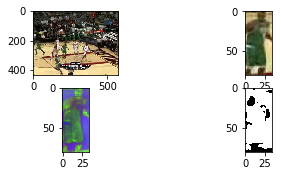

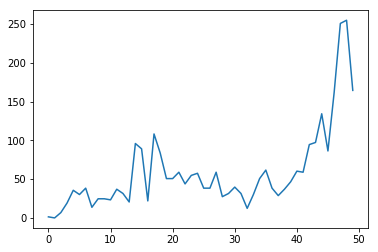

ROI hist


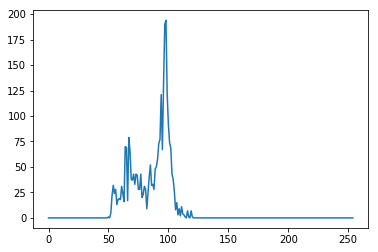

In [123]:
tracking_mean_shift('data/Basketball/img/', (198,214,34,81), hue_range=(50, 100), debug=True)

In [127]:
tracking_mean_shift('data/Biker/img/', (262, 94, 16, 26), hue_range=(90, 120), debug = False)

In [119]:
tracking_mean_shift('data/BlurBody/img/', (400, 48, 87, 319), hue_range=(10, 30), debug=False)

In [120]:
tracking_mean_shift('data/BlurCar2/img/', (227,207,122,99), hue_range=(125, 130), debug=False)

In [122]:
tracking_mean_shift('data/Bird1/img/', (450,91,31,37), hue_range=(92, 97), debug = False)

# Camshift tracking

In [128]:
# https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_mean_shift_tracking_segmentation.php
# https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=calcbackproject
# https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/

def tracking_cam_shift(path_to_dataset, roi, hue_range = (120, 180), debug = False):
    frame = imread(path_to_dataset + '/0001.jpg')
    (x,y,w,h) = roi
    track_window = roi

    # set up the ROI for tracking
    roi = frame[y:y+h, x:x+w]

    # convert BGR image to HSV
    hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # set threshold the HSV image to get certain color
    # H – Hue ( Dominant Wavelength ).
    # S – Saturation ( Purity / shades of the color ).
    # V – Value ( Intensity ).
    start_hue = hue_range[0]
    end_hue = hue_range[1]
    mask = cv2.inRange(hsv_roi, np.array((start_hue, 60.,32.)), np.array((end_hue,255.,255.)))
    
    # images : it is the source image of type uint8 or float32. it should be given in square brackets, ie, "[img]".
    # channels : it is also given in square brackets. It is the index of channel for which we calculate histogram. 
    #            For example, if input is grayscale image, its value is [0]. For color image, you can pass [0], [1] or [2] 
    #            to calculate histogram of blue, green or red channel respectively.
    # mask : mask image. To find histogram of full image, it is given as "None". But if you want to find histogram 
    #        of particular region of image, you have to create a mask image for that and give it as mask.
    # histSize : this represents our BIN count. Need to be given in square brackets. For full scale, we pass [256].
    # ranges : this is our RANGE. Normally, it is [0,256].
    roi_hist = cv2.calcHist([hsv_roi],[0],mask,[end_hue-start_hue],[start_hue, end_hue])
    
    # src – input array.
    # dst – output array of the same size as src .
    # alpha – norm value to normalize to or the lower range boundary in case of the range normalization.
    # beta – upper range boundary in case of the range normalization; it is not used for the norm normalization.
    # normType – normalization type (see the details below).
    # dtype – when negative, the output array has the same type as src; otherwise, it has the same number of channels as src and the depth =CV_MAT_DEPTH(dtype).
    # mask – optional operation mask.
    cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
    
    if debug == True:
        plt.subplot(321), plt.imshow(frame, 'gray')
        plt.subplot(322), plt.imshow(roi, 'gray')
        plt.subplot(323), plt.imshow(hsv_roi,'gray')
        plt.subplot(324), plt.imshow(mask, 'gray')
        plt.show()
        plt.plot(roi_hist)
        plt.show()
        create_and_draw_hist(roi)

    # Setup the termination criteria, either 10 iteration or move by at least 1 pt
    term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

    for filename in sorted(glob.glob(path_to_dataset + '/*.jpg')):
        frame = imread(filename)
        ret = True
        if ret == True:
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# images – Source arrays. They all should have the same depth, CV_8U or CV_32F , and the same size. 
#          Each of them can have an arbitrary number of channels.
# nimages – Number of source images.
# channels – The list of channels used to compute the back projection. The number of channels must match the histogram dimensionality. 
#            The first array channels are numerated from 0 to images[0].channels()-1 , 
#            the second array channels are counted from images[0].channels() to images[0].channels() + images[1].channels()-1, and so on.
# hist – Input histogram that can be dense or sparse.
# backProject – Destination back projection array that is a single-channel array of the same size and depth as images[0] .
# ranges – Array of arrays of the histogram bin boundaries in each dimension. See calcHist() .
# scale – Optional scale factor for the output back projection.
# uniform – Flag indicating whether the histogram is uniform or not (see above).
            prob_image = cv2.calcBackProject([hsv],[0],roi_hist,[start_hue,end_hue],1)

            # apply camshift to get the new location and rectangle size
            ret, track_window = cv2.CamShift(prob_image, track_window, term_crit)
            
            # Draw it on image
            pts = cv2.boxPoints(ret)
            pts = np.int0(pts)
            img2 = cv2.polylines(frame,[pts],True, 255,2)
            cv2.imshow('img2',img2)
            
            k = cv2.waitKey(60) & 0xff
            if k == 27:
                break
            else:
                cv2.imwrite(chr(k)+".jpg",img2)

        else:
            break

    cv2.destroyAllWindows()
# need on mac
    cv2.waitKey(1)

In [129]:
tracking_cam_shift('data/Basketball/img/', (198,214,34,81), hue_range=(60, 75), debug=False)

In [130]:
tracking_cam_shift('data/Biker/img/', (262, 94, 16, 26), hue_range=(90, 120), debug = False)

In [132]:
tracking_cam_shift('data/BlurBody/img/', (400, 48, 87, 319), hue_range=(10, 30), debug=False)

In [81]:
tracking_cam_shift('data/BlurCar2/img/', (227,207,122,99), hue_range=(125, 130), debug=False)

In [82]:
tracking_cam_shift('data/Bird1/img/', (450,91,31,37), hue_range=(92, 97), debug = False)

Max-min before normalization 31592.0 0.0
Max-min after normalization 255.0 0.0


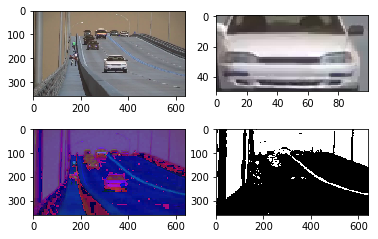

In [9]:
# cap = cv2.VideoCapture('videos/slow_traffic_small.mp4')

# # take first frame of the video
ret, frame = cap.read()

# setup initial location of window
# y,h,x,w - region of image
#           simply hardcoded the values
y,h,x,w = 200,50,300,100  
track_window = (x,y,w,h)

# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]

# convert BGR image to HSV
hsv_roi =  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# set threshold the HSV image to get certain color
# H – Hue ( Dominant Wavelength ).
# S – Saturation ( Purity / shades of the color ).
# V – Value ( Intensity ).
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))

# images : it is the source image of type uint8 or float32. it should be given in square brackets, ie, "[img]".
# channels : it is also given in square brackets. It is the index of channel for which we calculate histogram. For example, if input is grayscale image, its value is [0]. For color image, you can pass [0], [1] or [2] to calculate histogram of blue, green or red channel respectively.
# mask : mask image. To find histogram of full image, it is given as "None". But if you want to find histogram of particular region of image, you have to create a mask image for that and give it as mask.
# histSize : this represents our BIN count. Need to be given in square brackets. For full scale, we pass [256].
# ranges : this is our RANGE. Normally, it is [0,256].
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

# src – input array.
# dst – output array of the same size as src .
# alpha – norm value to normalize to or the lower range boundary in case of the range normalization.
# beta – upper range boundary in case of the range normalization; it is not used for the norm normalization.
# normType – normalization type (see the details below).
# dtype – when negative, the output array has the same type as src; otherwise, it has the same number of channels as src and the depth =CV_MAT_DEPTH(dtype).
# mask – optional operation mask.
print("Max-min before normalization", roi_hist.max(), roi_hist.min())
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
print("Max-min after normalization", roi_hist.max(), roi_hist.min())

plt.subplot(221), plt.imshow(frame, 'gray')
plt.subplot(222), plt.imshow(roi, 'gray')
plt.subplot(223), plt.imshow(hsv_roi,'gray')
plt.subplot(224), plt.imshow(mask, 'gray')
# plt.subplot(225), plt.imshow(roi_hist, 'gray')
# plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
# plt.xlim([0,256])
plt.show()

# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
# images – Source arrays. They all should have the same depth, CV_8U or CV_32F , and the same size. Each of them can have an arbitrary number of channels.
# nimages – Number of source images.
# channels – The list of channels used to compute the back projection. The number of channels must match the histogram dimensionality. The first array channels are numerated from 0 to images[0].channels()-1 , the second array channels are counted from images[0].channels() to images[0].channels() + images[1].channels()-1, and so on.
# hist – Input histogram that can be dense or sparse.
# backProject – Destination back projection array that is a single-channel array of the same size and depth as images[0] .
# ranges – Array of arrays of the histogram bin boundaries in each dimension. See calcHist() .
# scale – Optional scale factor for the output back projection.
# uniform – Flag indicating whether the histogram is uniform or not (see above).
        prob_image = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(prob_image, track_window, term_crit)

        # Draw it on image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv2.imshow('img2', img2)

        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)
cap.release()